# SYDE 552: Assignment 2

Due: Feb 23, 2021

The purpose of this assignment is to train some deep networks to recognize images.  We will start with MNIST (the standard hand-written numbers dataset) and then go on to the harder CIFAR-10 (recognizing pictures in 10 categories).

All of these datasets are publically available, and you can technically use whatever programming language you want to do the deep network, but we *highly* recommend using the Python package `tensorflow`.  It has become the industry standard.  You can use other systems if you would like, as pretty much any deep learning library should support the aspects covered in this assignment.  We'd also recommend using the most recent version (Tensorflow 2).  On most python systems this can be installed with:

```
pip install tensorflow
```

For more information on installing, see https://www.tensorflow.org/install

For this assignment, you will not need to install the GPU version of `tensorflow`.  If you want to work with larger deep learning models and make things run faster (for your project, for example), then instructions for doing so are at https://www.tensorflow.org/install/gpu

This assignment sheet is a Jupyter Notebook file https://jupyter.org/ which you can use if you want as a starting point.

## Part 1: MNIST

First, we download the data files.  They are already split into a training set and a test set.

In [78]:
import tensorflow.keras.datasets.mnist as mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0   # rescale the images to be between 0 and 1
x_test = x_test / 255.0     # rescale the images to be between 0 and 1

Let's show the first 10 training images and their category labels.

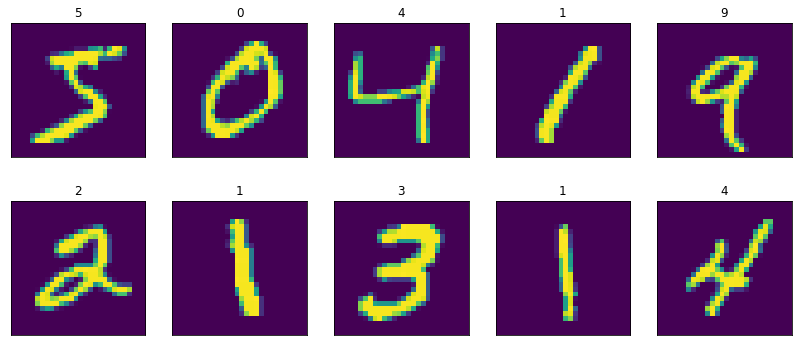

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('%d' % y_train[i])
plt.show()

The `y_train` and `y_target` values are currently integers (0 to 9).  The output from our network is a vector where one value should be 1 and the others should be 0, so we need to convert to that format.  (Note: there is a special loss function `sparse_categorical_crossentropy` that automatically converts for us.  We'll use that later, but for now do this manually, just to keep things clear.)

In [52]:
import numpy as np

y_train_target = np.eye(10)[y_train]
y_test_target = np.eye(10)[y_test]
print('original target:', y_train[0])
print('  vector target:', y_train_target[0])

original target: 5
  vector target: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Now we define the model using Keras https://keras.io/, which is meant for being able to quickly define all the different structures you might want to add to your network. We use `Sequential` to indicate that this is just a big feed-forward network, and we define each layer in turn.  `Dense` is a layer where all the components are connected to all of the previous layer's outputs.

In [79]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
])

# define what we want to minimize (the thing that we take the derivative of to get the weight changes)
def my_loss(y_true, y_predict):
    return (y_true-y_predict)**2

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
              loss=my_loss,
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

Before doing any training, let's see how well it performs.

In [57]:
loss, accuracy = model.evaluate(x_test,  y_test_target)

10000/10000 [==============================] - 1s 69us/sample - loss: 0.1297 - accuracy: 0.0798


As expected, it's pretty bad, since we haven't done any training yet.  The accuracy is near 10%, which is what we would expect by chance.  But what actual numbers is it outputting?

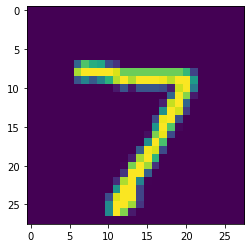

actual output from network: [0.49270982 0.         0.         0.2484155  0.         0.9739701
 0.5341619  0.         0.         0.        ]
category (the largest output): 5


In [6]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])


So it currently thinks the first image in the test dataset is is a 4, when it should actually be a 7 (note: when you run this, you may get a different number, as each network starts out randomly different).  

Now let's try training the model.  We'll just do 5 epochs of training (5 times through all the training data).  While it is training, we also tell it to see how well the model is performing on the testing data (technically this is considered to be validation data).

In [58]:
model.fit(x_train, y_train_target, epochs=5, validation_data=(x_test, y_test_target));

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.0405 - accuracy: 0.7290 - val_loss: 0.0286 - val_accuracy: 0.8187
Epoch 2/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0275 - accuracy: 0.8228 - val_loss: 0.0252 - val_accuracy: 0.8382
Epoch 3/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0250 - accuracy: 0.8363 - val_loss: 0.0235 - val_accuracy: 0.8445
Epoch 4/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0235 - accuracy: 0.8435 - val_loss: 0.0225 - val_accuracy: 0.8502
Epoch 5/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0226 - accuracy: 0.8483 - val_loss: 0.0217 - val_accuracy: 0.8535


We can plot the categorization accuracy over time and the error over time for both the training set and the test set.

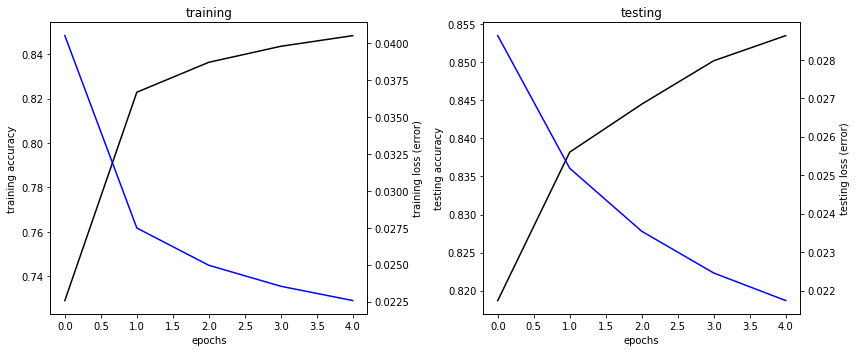

In [59]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

Now let's see how well it performs on the test set.

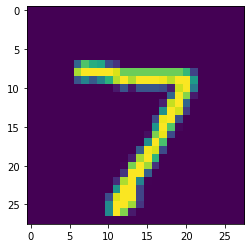

actual output from network: [0.         0.         0.         0.         0.         0.
 0.         0.92309827 0.         0.        ]
category (the largest output): 7


In [60]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])

Well it learned the first item well, but it's only getting around 85% on the test set (which is also about what it's getting on the training set).  To get a better sense of what it's doing, let's generate the *confusion* matrix.  This indicates what category it puts things in, as compared to what category they should be in.

In [61]:
confusion=np.zeros((10,10), dtype=int)
np.add.at(confusion, (category, y_test), 1)
print(confusion)

[[ 967    0   14    2    4   17  605    1   13   13]
 [   0 1115    3    1    2    3    5   10    4    6]
 [   2    7  967   17    7    3  141   22    4    1]
 [   2    4    8  950    2   19    4    4    9   11]
 [   1    0   11    0  915    9   70   11    9   21]
 [   1    1    1   12    2  818   80    1    9    5]
 [   0    0    0    0    0    0    0    0    0    0]
 [   2    2    8   10    3    4    0  960   11   11]
 [   5    6   20   13    7   13   48    4  909    7]
 [   0    0    0    5   40    6    5   15    6  934]]


The ideal confusion matrix will have ~1000 along the diagonal and 0 everywhere else.  According to this confusion matrix (yours will be different), nothing got classified as a 9 (bottom row is all zeros) and instead 9s were classified as everything else, but mostly as 0s and 4s (308 of the 9s are classified as 0s, and 264 of the 9s are classified as 4s).   

**1. [1 mark]:** Run the MNIST model as defined here 10 times.  Note that you have to re-create the `model` each time: if you just run `model.fit` over again, then it will just train the same model, continuing from where it left off.  Each of the 10 models should be trained for 5 epochs.  Make a single plot with training accuracy vs epoch for all 10 runs. You should see that each time you train the model, it behaves differently.  Why does this happen? 


run 0
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 95us/sample - loss: 0.0320 - accuracy: 0.8187 - val_loss: 0.0201 - val_accuracy: 0.9075
Epoch 2/5
60000/60000 [==============================] - 6s 95us/sample - loss: 0.0188 - accuracy: 0.9141 - val_loss: 0.0166 - val_accuracy: 0.9252
Epoch 3/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0163 - accuracy: 0.9283 - val_loss: 0.0150 - val_accuracy: 0.9347
Epoch 4/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0148 - accuracy: 0.9353 - val_loss: 0.0139 - val_accuracy: 0.9381
Epoch 5/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0138 - accuracy: 0.9407 - val_loss: 0.0131 - val_accuracy: 0.9419

run 1
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0312 - accuracy: 0.8248 - val_loss: 0.0196 - val_accuracy: 0.91

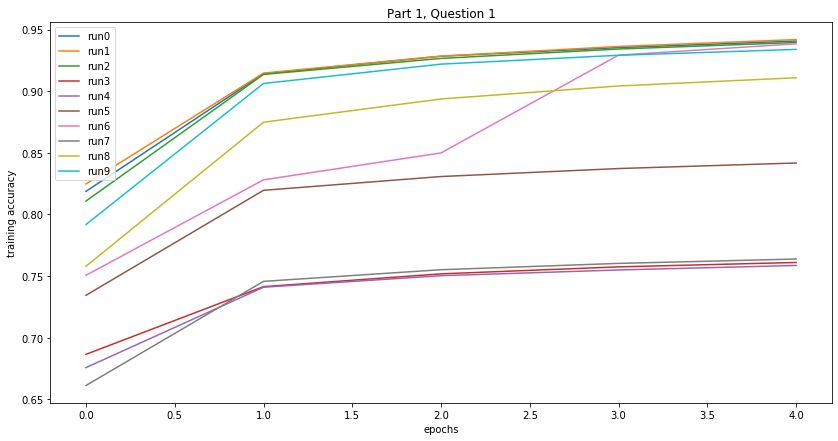

In [62]:
plt.figure(figsize=(14,7))
for n in range(10):
    print(f'\nrun {n}')
    # The following code is the same as above
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train_target, epochs=5, validation_data=(x_test, y_test_target));
    
    plt.plot(model.history.history['accuracy'], label=f'run{n}')

plt.title('Part 1, Question 1')
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.legend()
plt.show()

The tensorflow Sequential model used initializes the starting weights to random values, resulting in different starting weights at each run. This affects how it updates the weights at its next iteration. If we were to only perform one run, we may not get an accuract understanding of the model's performance - as shown in the graphs above, the difference between the models is substantial.

**2. [1 mark]:** Do the same thing as question 1, but train for 20 epochs.  Plot the training error vs epochs for 10 different runs on one plot.  On a separate plot show the testing error vs epochs for the 10 different runs.  How does the testing error compare to the training error?  Do the models all eventually learn to solve the problem well?  What happens to them?


***run 0

***run 1

***run 2

***run 3

***run 4

***run 5

***run 6

***run 7

***run 8

***run 9


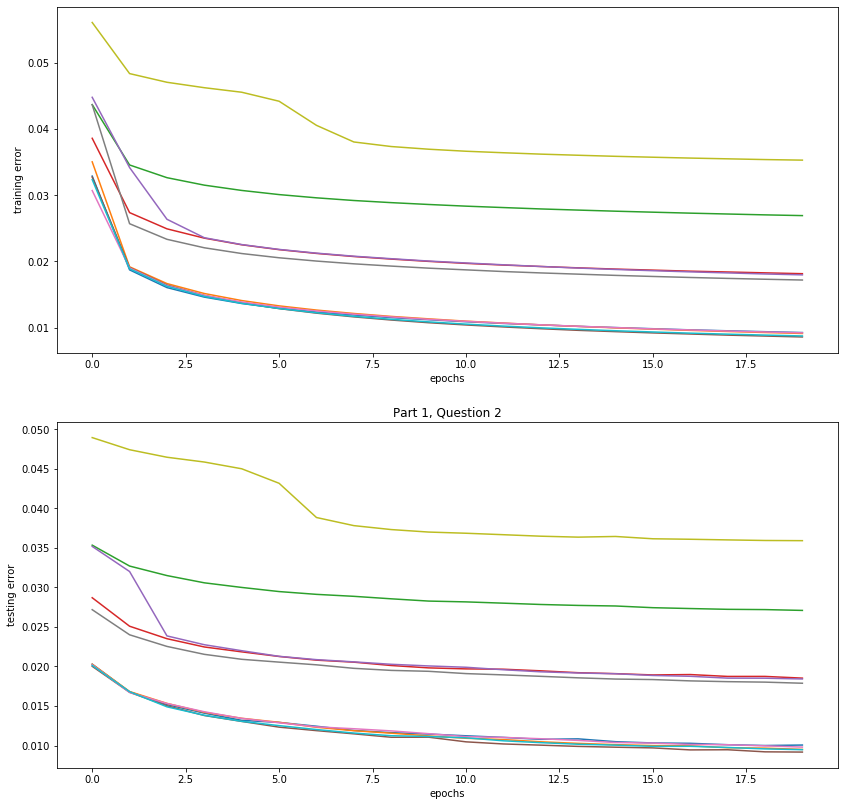

In [11]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'\n***run {n}') # To see progress
    # The following code is the same as above
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train_target, epochs=20, validation_data=(x_test, y_test_target), verbose=0)
    ax[0].plot(model.history.history['loss'])
    ax[1].plot(model.history.history['val_loss'])

plt.title('Part 1, Question 2')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training error')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing error')
plt.show()

The testing and training error follow a similar pattern, decreasing at similar rates. The training 

**3. [1 mark]:** Repeat question 2 (generating the same 2 plots), but with a learning rate of 0.01.  How does this affect the learning performance?


run 0

run 1

run 2

run 3

run 4

run 5

run 6

run 7

run 8

run 9


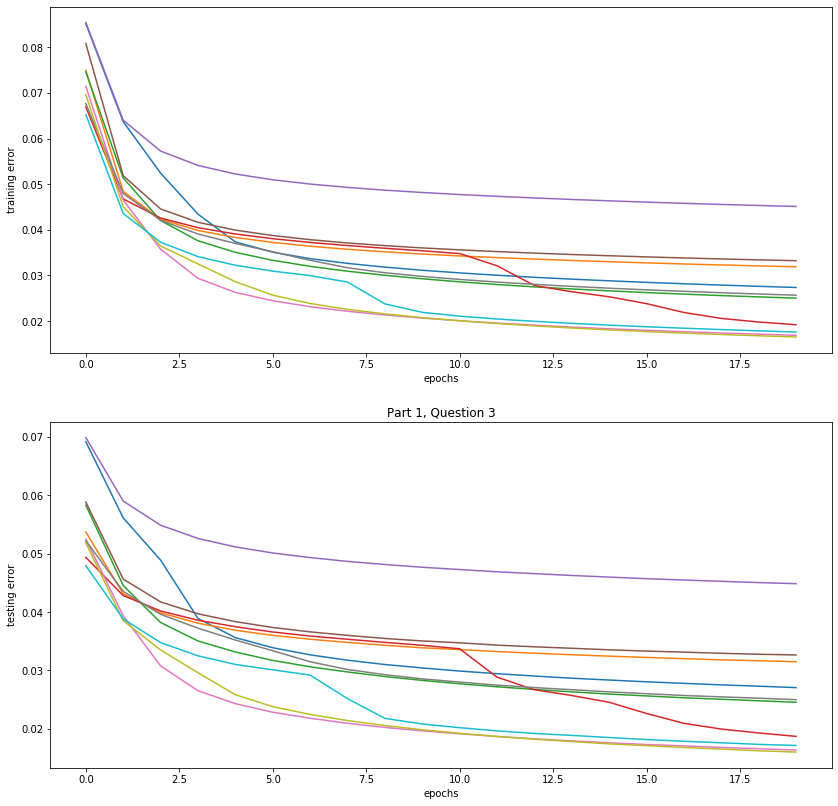

In [12]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'\nrun {n}')    # To see progress
    # The following code is the same as above
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train_target, epochs=20, validation_data=(x_test, y_test_target), verbose=0)
    ax[0].plot(model.history.history['loss'])
    ax[1].plot(model.history.history['val_loss'])

plt.title('Part 1, Question 3')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training error')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing error')
plt.show()

With a lower learning rate, the performance is much better, with a few models reaching less than 2% testing error. The inital performance in the first few epochs is worse than the previous model with `learning_rate=0.1`, but the error reduces at a faster rate.

**4. [1 mark]:** Instead of standard Stochastic Gradient Descent, most modern machine learning researchers use a variation of it called Adam that automatically adjusts the learning rate and does a better local estimate of the gradient.  We can switch to this by changing `optimizer=tf.keras.optimizers.SGD(learning_rate=0.1)` to `optimizer="adam"`.  Repeat question 2 (generating the same 2 plots) using the Adam optimizer.  How does this affect the learning performance?

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9


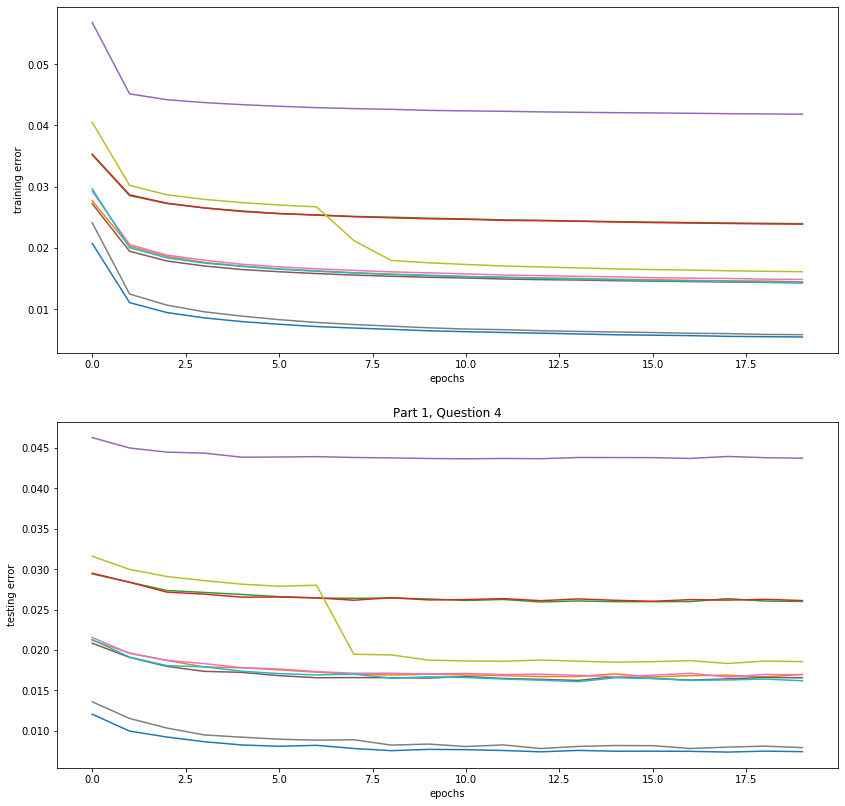

In [17]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    # The following code is the same as above
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])

    model.compile(optimizer='adam', loss=my_loss,metrics=['accuracy'])

    model.fit(x_train, y_train_target, epochs=20, validation_data=(x_test, y_test_target),verbose=0)
    ax[0].plot(model.history.history['loss'])
    ax[1].plot(model.history.history['val_loss'])

plt.title('Part 1, Question 4')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training error')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing error')
plt.show()

Using the Adam optimizer improves the model's performance. With the regular SGD method, the validation error converges around 2-5%. With the Adam variation, validation error converges around 0.5-4.5%, with most of the models reaching below 3% error.

**5. [1 mark]**: To improve performance, we can also change the output layer of neurons to be a `softmax` layer.  This means that they will automatically be normalized with the softmax function (so the output of neuron $i$ will be ${e^{a_i} / \sum_j e^{a_j}}$).  This should push the output value closer to the sort of output we want (all zeros with a single 1).  Furthermore, instead of doing the error as $(t-y)^2$, we can instead choose an error function that is only concerned about categorization.  After all, the only thing we care about when categorizing is which of the outputs is largest, not whether they are exactly 0 or 1.  Conveniently, tensorflow (and many other deep learning libraries) also contains a version of this function that works directly on category labels, so we don't have to do the `y_train_target = np.eye(10)[y_train]` trick in the code above.  The resulting network looks like this:

Generate the same 2 plots as in question 2.  How do these changes affect the learning performance?

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9


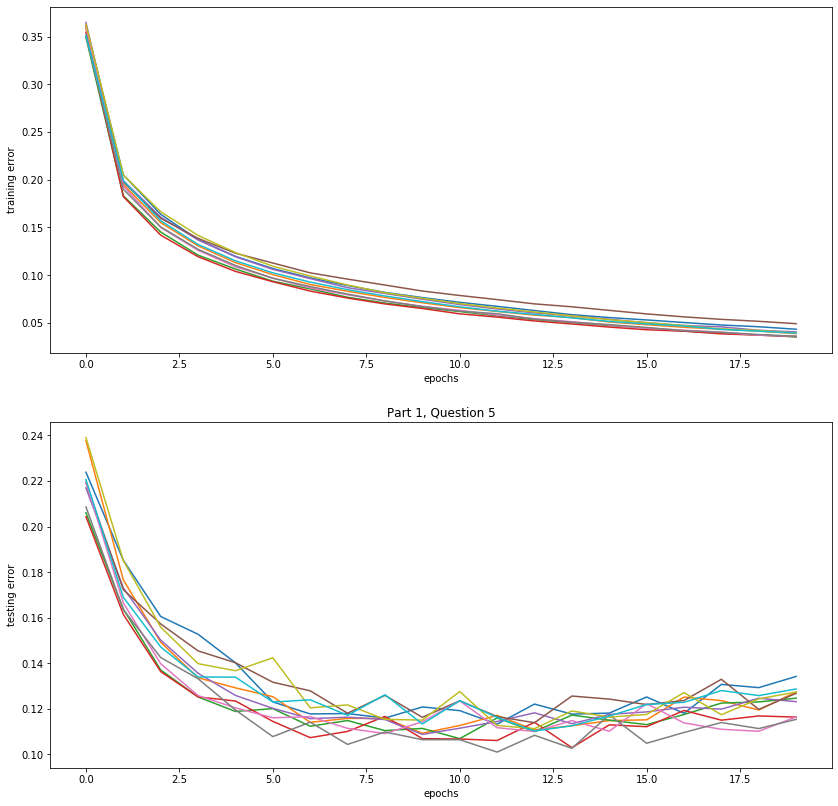

In [63]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test),verbose=0)   # note that we now use y_train, not y_train_target
    ax[0].plot(model.history.history['loss'])
    ax[1].plot(model.history.history['val_loss'])

plt.title('Part 1, Question 5')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training error')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing error')
plt.show()

With the output softmax layer, the model converges sooner, reaching an error rate of 10-14% in 5 epochs. However, the error is higher.

**6. [2 marks]:** Using the final version of the model (from question 5), explore the performance of the model as you change the number of neurons in the hidden layer.  Try 2, 4, 8, 16, 32, 64, 128, and 256.  For each value, train 10 models for 10 epochs each.  Set `epochs=10`.  Plot the average training accuracy vs different numbers of neurons.  On a separate plot, plot the average testing accuracy vs different numbers of neurons.  What trend do you observe?

run 0, 2 neurons
run 1, 2 neurons
run 2, 2 neurons
run 3, 2 neurons
run 4, 2 neurons
run 5, 2 neurons
run 6, 2 neurons
run 7, 2 neurons
run 8, 2 neurons
run 9, 2 neurons
run 0, 4 neurons
run 1, 4 neurons
run 2, 4 neurons
run 3, 4 neurons
run 4, 4 neurons
run 5, 4 neurons
run 6, 4 neurons
run 7, 4 neurons
run 8, 4 neurons
run 9, 4 neurons
run 0, 8 neurons
run 1, 8 neurons
run 2, 8 neurons
run 3, 8 neurons
run 4, 8 neurons
run 5, 8 neurons
run 6, 8 neurons
run 7, 8 neurons
run 8, 8 neurons
run 9, 8 neurons
run 0, 16 neurons
run 1, 16 neurons
run 2, 16 neurons
run 3, 16 neurons
run 4, 16 neurons
run 5, 16 neurons
run 6, 16 neurons
run 7, 16 neurons
run 8, 16 neurons
run 9, 16 neurons
run 0, 32 neurons
run 1, 32 neurons
run 2, 32 neurons
run 3, 32 neurons
run 4, 32 neurons
run 5, 32 neurons
run 6, 32 neurons
run 7, 32 neurons
run 8, 32 neurons
run 9, 32 neurons
run 0, 64 neurons
run 1, 64 neurons
run 2, 64 neurons
run 3, 64 neurons
run 4, 64 neurons
run 5, 64 neurons
run 6, 64 neurons
run 

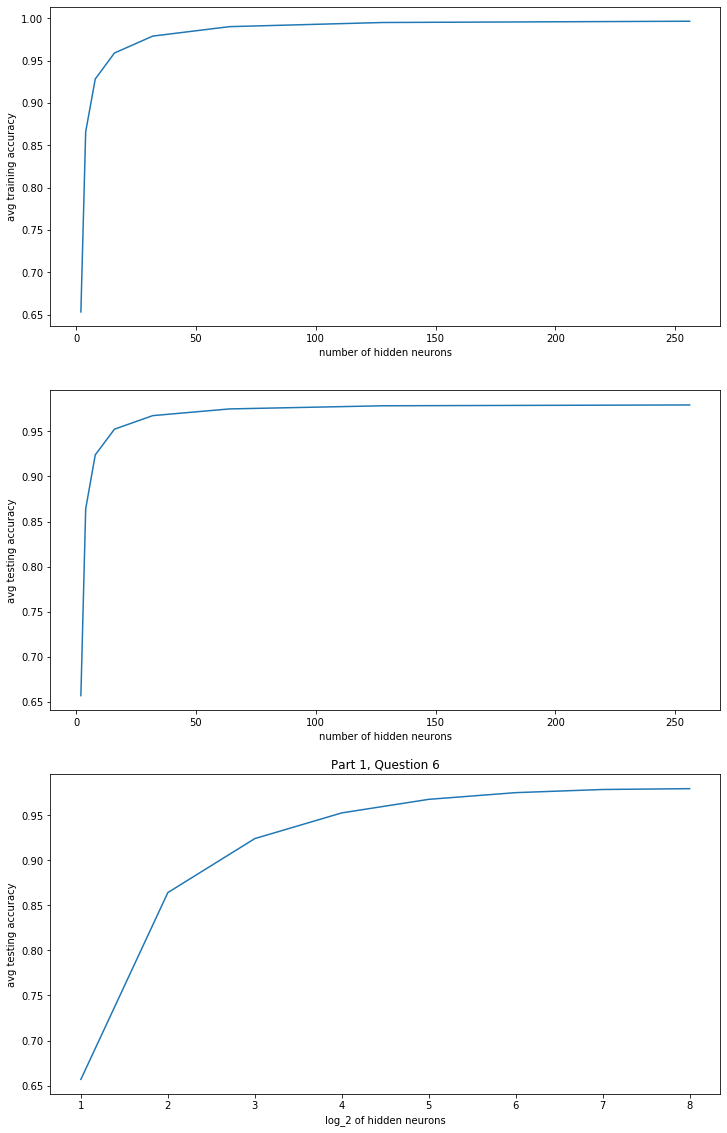

In [70]:
# Note: Switched to plotting accuracy instead of loss from this point forward
from statistics import mean
from math import log

fig, ax = plt.subplots(3, figsize=(12,20))
hidden_neurons = [2,4,8,16,32,64,128,256]

avg = []
val_avg = []
for n_hidden in hidden_neurons:
    accuracy = []
    val_accuracy = []
    for n in range(10):
        print(f'run {n}, {n_hidden} neurons')    # to monitor progress
        model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
        tf.keras.layers.Dense(n_hidden, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
        ])

        model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

        model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
        
        accuracy.append(model.history.history['accuracy'][-1])
        val_accuracy.append(model.history.history['val_accuracy'][-1])
        
    avg.append(mean(accuracy))
    val_avg.append(mean(val_accuracy))
        
ax[0].plot(hidden_neurons, avg)
ax[1].plot(hidden_neurons, val_avg)
ax[2].plot([log(i,2) for i in hidden_neurons], val_avg)

plt.title('Part 1, Question 6')
ax[0].set_xlabel('number of hidden neurons')
ax[0].set_ylabel('avg training accuracy')
ax[1].set_xlabel('number of hidden neurons')
ax[1].set_ylabel('avg testing accuracy')
ax[2].set_xlabel('log_2 of hidden neurons')
ax[2].set_ylabel('avg testing accuracy')
plt.show()

The plots above show that accuracy increases rapidly until 32 neurons in the hidden layer. After that point, as the number of neurons doubles, the increase in accuracy is very slight.

**7. [2 marks]:** The overall goal is to make the network perform as well as possible on the testing data.  What would you do if your job was to make the best possible network for this task?  Try some things and report your results.  For example, try adding a second hidden layer to the model.  Try making it different sizes. What about having no hidden layer?  Or more than 2?  Report the results of your exploration.

**(A)** Adding a second hidden layer

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9


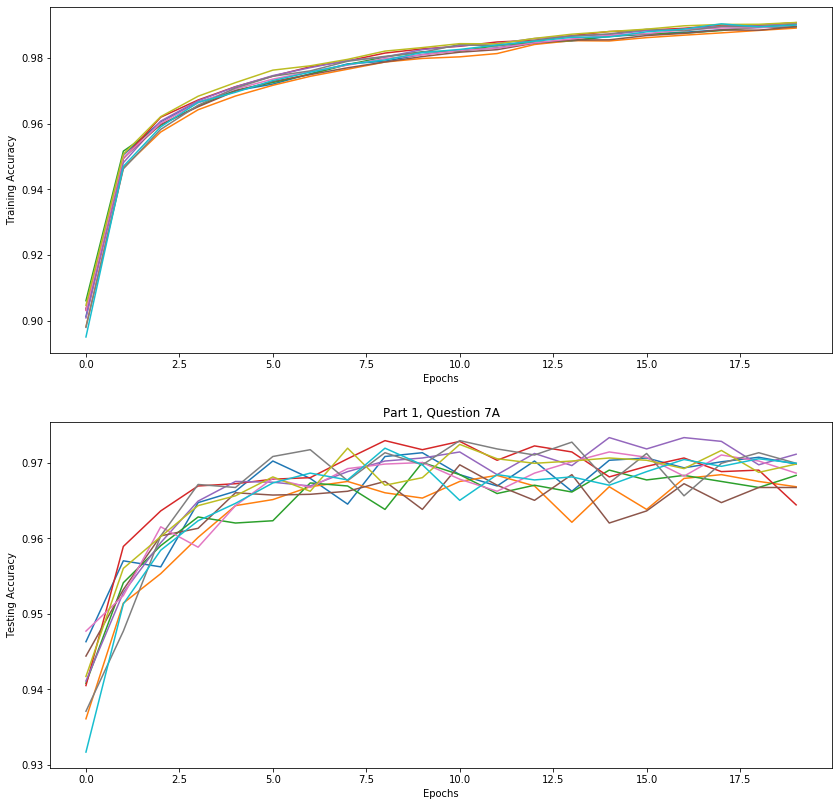

In [72]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test),verbose=0)   # note that we now use y_train, not y_train_target
    ax[0].plot(model.history.history['accuracy'])
    ax[1].plot(model.history.history['val_accuracy'])

plt.title('Part 1, Question 7A')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Testing Accuracy')
plt.show()

With a second hidden layer, the accuracy increases, and begins to converge earlier after only 5 epochs.

**(B)** No hidden layer

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9


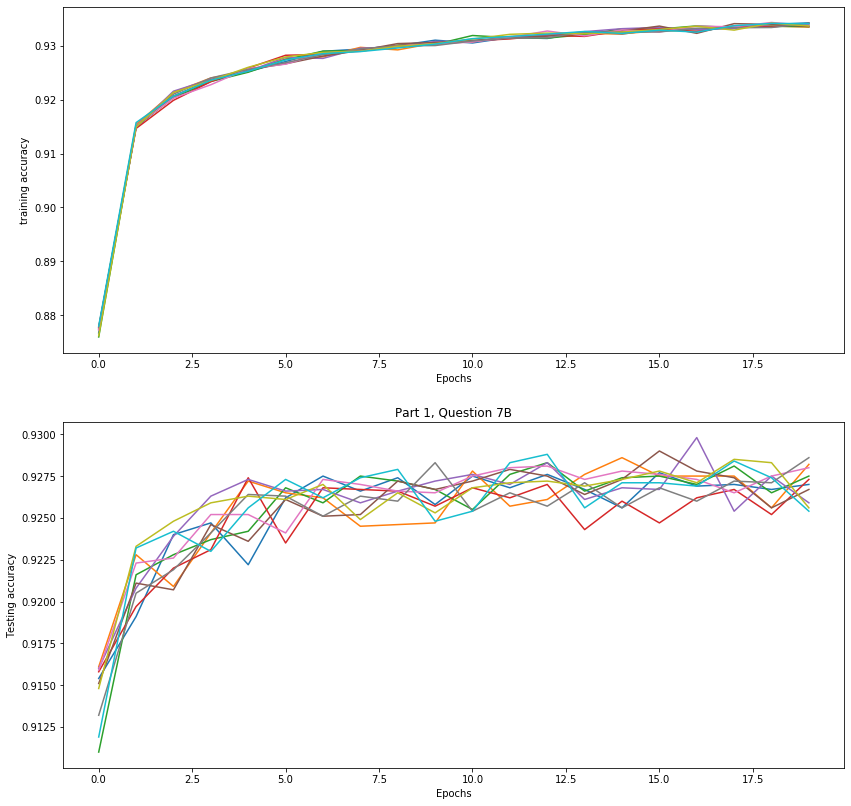

In [71]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test),verbose=0)   # note that we now use y_train, not y_train_target
    ax[0].plot(model.history.history['accuracy'])
    ax[1].plot(model.history.history['val_accuracy'])

plt.title('Part 1, Question 7B')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('training accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Testing accuracy')
plt.show()

With no hidden layer, the accuracy is lower, though still pretty high

**(C)** Two extra hidden layers of 16 neurons, instead of one with 32 neurons

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9


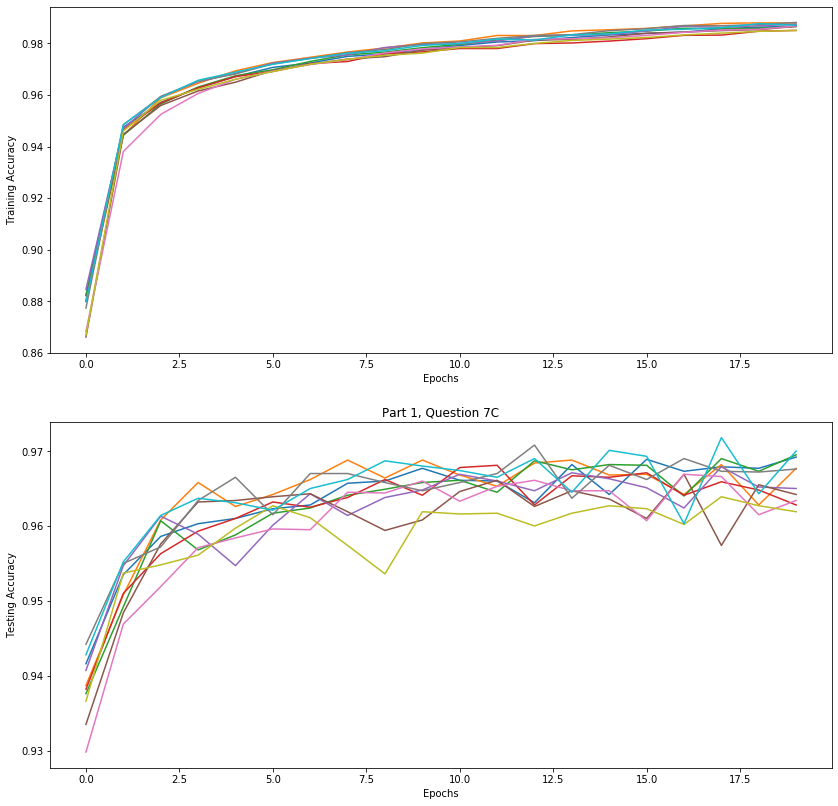

In [73]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test),verbose=0)   # note that we now use y_train, not y_train_target
    ax[0].plot(model.history.history['accuracy'])
    ax[1].plot(model.history.history['val_accuracy'])

plt.title('Part 1, Question 7C')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Testing Accuracy')
plt.show()

Two hidden layers of 16 neurons performs similarly to one with 32 neurons.

## Part 2: CIFAR-10

The CIFAR-10 dataset is a bit harder than the MNIST dataset.  Like MNIST, it consists of 10 categories of images, but now they are colour images and they are of different types of objects.

In [80]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Scale pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0
y_test = y_test[:,0]

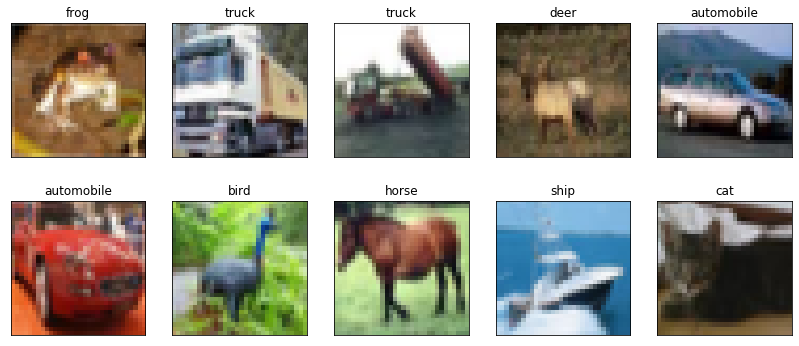

In [81]:
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[int(y_train[i])])
plt.show()

**8. [2 marks]:** Try using the same model as we used for the MNIST (question 5) task to categorize these images.  You will need to change `input_shape=(28, 28)` to `input_shape=(32, 32, 3)`, as these are now colour images of a different size.  Use 32 neurons in the hidden layer and train for 10 epochs.  Do this 10 times and plot the training accuracy and testing accuracy.  How well does the model perform?  Try increasing the number of hidden layer neurons (pick a number of neurons that seems reasonable given how much computer processing power you have).  How much does the system improve?

run 0
Validation accuracy:  [0.1826, 0.1858, 0.1899, 0.1864, 0.18, 0.1928, 0.1884, 0.1875, 0.1893, 0.1909]
run 1
Validation accuracy:  [0.2094, 0.247, 0.2438, 0.2531, 0.249, 0.2533, 0.2582, 0.2535, 0.2424, 0.2619]
run 2
Validation accuracy:  [0.2368, 0.2555, 0.2546, 0.2534, 0.2551, 0.2455, 0.252, 0.2399, 0.2528, 0.2556]
run 3
Validation accuracy:  [0.2385, 0.2942, 0.3026, 0.3054, 0.2782, 0.3152, 0.3194, 0.319, 0.3131, 0.3202]
run 4
Validation accuracy:  [0.2012, 0.2473, 0.248, 0.2506, 0.2581, 0.2629, 0.2534, 0.2601, 0.261, 0.2635]
run 5
Validation accuracy:  [0.1751, 0.1885, 0.1814, 0.1698, 0.183, 0.1886, 0.1911, 0.1894, 0.1809, 0.1793]
run 6
Validation accuracy:  [0.2982, 0.2917, 0.314, 0.3225, 0.3252, 0.3274, 0.3325, 0.3362, 0.3277, 0.3354]
run 7
Validation accuracy:  [0.3164, 0.3075, 0.333, 0.339, 0.3378, 0.3389, 0.3439, 0.3469, 0.3419, 0.327]
run 8
Validation accuracy:  [0.3036, 0.3239, 0.3247, 0.3059, 0.3208, 0.3137, 0.3166, 0.3164, 0.3172, 0.3313]
run 9
Validation accuracy:  [0.2

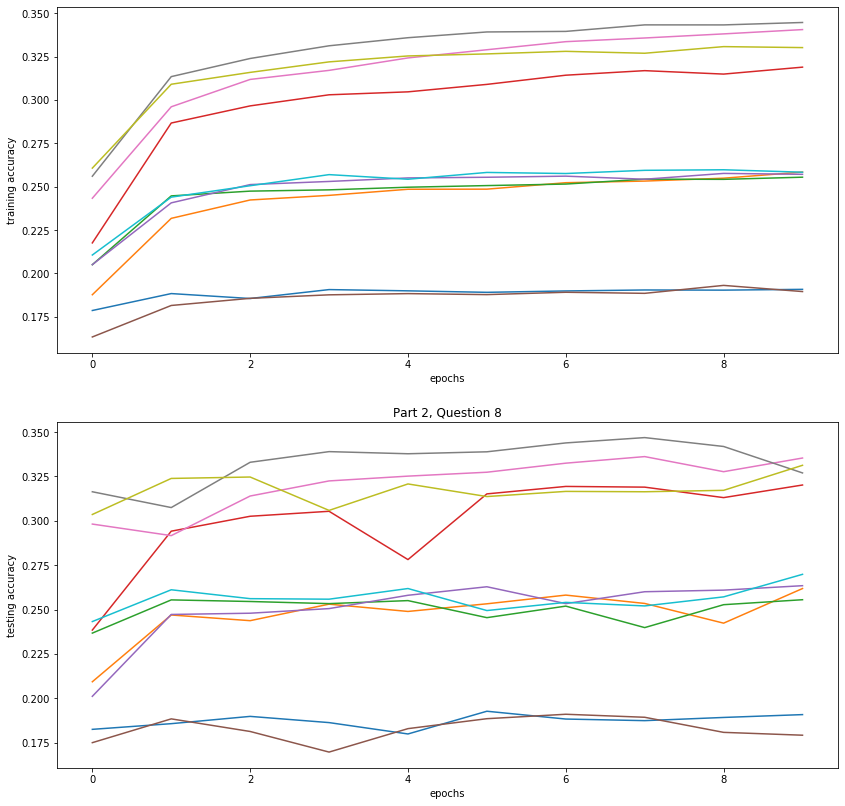

In [83]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test),verbose=0)   # note that we now use y_train, not y_train_target
    ax[0].plot(model.history.history['accuracy'])
    ax[1].plot(model.history.history['val_accuracy'])
    print('Validation accuracy: ', model.history.history['val_accuracy'])

plt.title('Part 2, Question 8')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing accuracy')
plt.show()

The system doesn't show very much improvement, with accuracy increasing only about 0.05 or less.

run 0
Validation accuracy:  [0.366, 0.3891, 0.3981, 0.3864, 0.4072, 0.4083, 0.395, 0.412, 0.4177, 0.4073]
run 1
Validation accuracy:  [0.3621, 0.3679, 0.3635, 0.3883, 0.3743, 0.3828, 0.4018, 0.3976, 0.4018, 0.3889]
run 2
Validation accuracy:  [0.3562, 0.3886, 0.4026, 0.4184, 0.4263, 0.4247, 0.4217, 0.4172, 0.4431, 0.4412]
run 3
Validation accuracy:  [0.365, 0.3903, 0.3905, 0.4313, 0.3991, 0.3952, 0.4309, 0.4416, 0.4257, 0.4443]
run 4
Validation accuracy:  [0.3774, 0.3812, 0.3915, 0.4193, 0.4221, 0.4021, 0.4244, 0.427, 0.4109, 0.4187]
run 5
Validation accuracy:  [0.3841, 0.3901, 0.4013, 0.4015, 0.4223, 0.4268, 0.4431, 0.4426, 0.4434, 0.4428]
run 6
Validation accuracy:  [0.3553, 0.3769, 0.3931, 0.3988, 0.4112, 0.3986, 0.3984, 0.4178, 0.4159, 0.4116]
run 7
Validation accuracy:  [0.3494, 0.366, 0.3932, 0.372, 0.3707, 0.4079, 0.4121, 0.4043, 0.4201, 0.413]
run 8
Validation accuracy:  [0.3363, 0.3832, 0.3764, 0.3909, 0.4046, 0.4128, 0.4134, 0.3927, 0.4106, 0.4199]
run 9
Validation accuracy: 

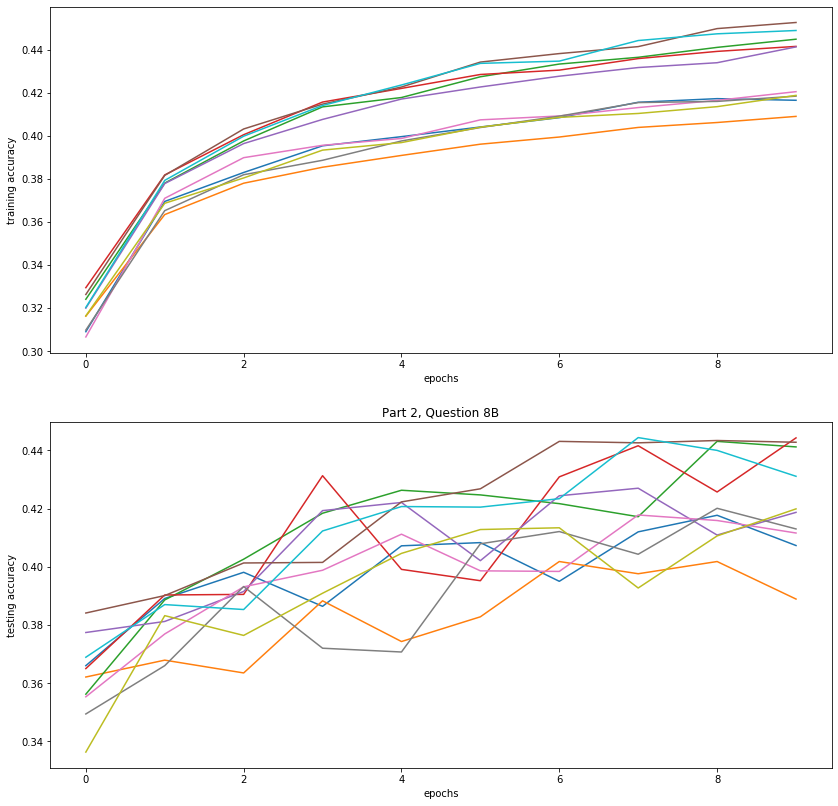

In [85]:
# Try with 128 hidden neurons

fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test),verbose=0)   # note that we now use y_train, not y_train_target
    ax[0].plot(model.history.history['accuracy'])
    ax[1].plot(model.history.history['val_accuracy'])
    print('Validation accuracy: ', model.history.history['val_accuracy'])

plt.title('Part 2, Question 8B')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing accuracy')
plt.show()

This increased the accuracy significantly, but it is still pretty low.

**9. [2 marks]:** To solve this task, let's try adding more layers.  In particular, let's add convolutional layers.  Here is a good network structure to start with:

In [ ]:
'''
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),    
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
'''

Train this network for 10 epochs, and do this 10 times and plot the training and testing accuracy.  How well does the model perform?  

run 0
Validation accuracy:  [0.5609, 0.622, 0.6575, 0.6718, 0.6748, 0.6735, 0.6991, 0.7147, 0.701, 0.7064]
run 1
Validation accuracy:  [0.5674, 0.6015, 0.6534, 0.6718, 0.694, 0.7023, 0.7139, 0.6964, 0.7196, 0.7188]
run 2
Validation accuracy:  [0.5601, 0.6138, 0.65, 0.6697, 0.6735, 0.6893, 0.7049, 0.6961, 0.7046, 0.6993]
run 3
Validation accuracy:  [0.5461, 0.6302, 0.6554, 0.6851, 0.6948, 0.6946, 0.707, 0.694, 0.6908, 0.7136]
run 4
Validation accuracy:  [0.5534, 0.6203, 0.6658, 0.6813, 0.6837, 0.6973, 0.6917, 0.7088, 0.7157, 0.7148]
run 5
Validation accuracy:  [0.5485, 0.6222, 0.647, 0.6618, 0.6865, 0.696, 0.7127, 0.7187, 0.6857, 0.7106]
run 6
Validation accuracy:  [0.5441, 0.5662, 0.6433, 0.6695, 0.6791, 0.6825, 0.6884, 0.7109, 0.7077, 0.7052]
run 7
Validation accuracy:  [0.5369, 0.606, 0.6393, 0.6836, 0.6925, 0.7088, 0.6947, 0.6996, 0.7266, 0.7256]
run 8
Validation accuracy:  [0.5281, 0.6284, 0.6452, 0.6631, 0.6911, 0.7002, 0.7004, 0.7017, 0.7101, 0.7177]
run 9
Validation accuracy:  [

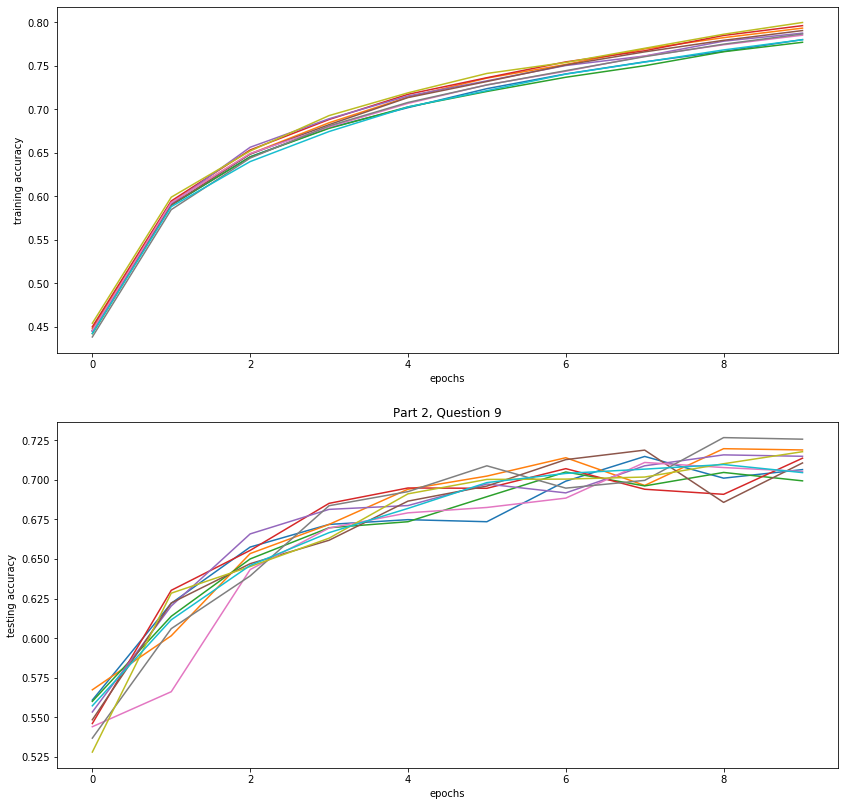

In [88]:
fig, ax = plt.subplots(2, figsize=(14,14))
for n in range(10):
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.Flatten(),    
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
    ax[0].plot(model.history.history['accuracy'])
    ax[1].plot(model.history.history['val_accuracy'])
    print('Validation accuracy: ', model.history.history['val_accuracy'])

plt.title('Part 2, Question 9')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing accuracy')
plt.show()

**10. [2 marks]:** Improve the model as much as you can.  Remember that the goal is to increase the testing accuracy, not the training accuracy (after all, if we wanted perfect training accuracy, we could just write code that just memorizes all the training data and uses it as a lookup table).  Report what things you tried and how much they helped (or did not help).

**(A)** First try: increase epochs from 10 to 16

Also reduced the number of runs slightly from 10 to 8 to reduce the runtime, since this doesn't impact the performance of the model itself.

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7


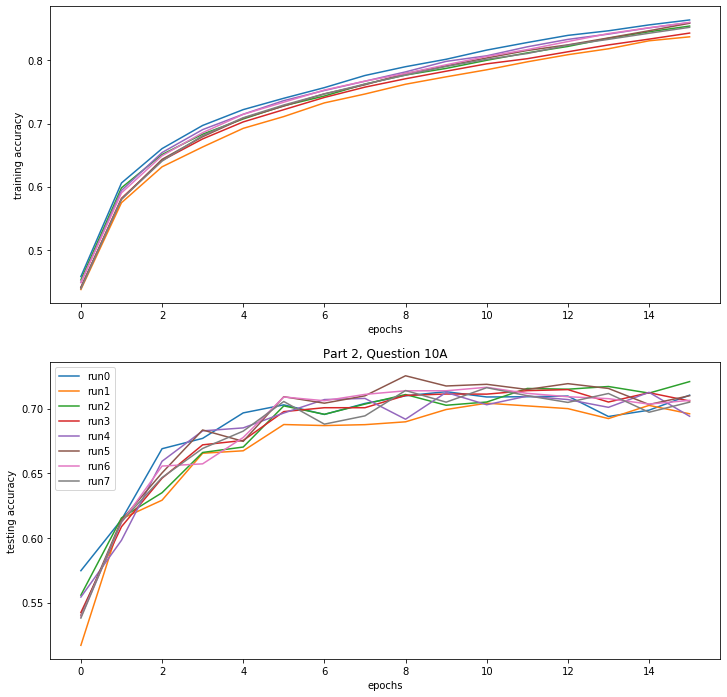

In [32]:
fig, ax = plt.subplots(2, figsize=(12,12))
for n in range(8):  # Reduced number of runs slightly to improve the runtime
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.Flatten(),    
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )

    model.fit(x_train, y_train, epochs=16, validation_data=(x_test, y_test), verbose=0)
    ax[0].plot(model.history.history['accuracy'], label=f'run{n}')
    ax[1].plot(model.history.history['val_accuracy'], label=f'run{n}')

plt.title('Part 2, Question 10A')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing accuracy')
ax[1].legend()
plt.show()

It looks like the extra epochs don't really help; while the training accuracy increased, the validation accuracy seems to actually decrease after around 12-14 epochs, so we'll leave it at 12

**(B)** Second try: In the graphs from Q6, we saw that increasing the number of neurons in a hidden layer from 32 to 64 does not give a significant improvement. In Question 8, increasing the number of neurons did improve the testing accuracy, but inconsistently, and not by a huge amount. So, we'll add another Dense layer and another Convolutional layer, both with 32 neurons 

run 0
Validation accuracy:  [0.5061, 0.5755, 0.6227, 0.6375, 0.6175, 0.6845, 0.69, 0.6797, 0.6898, 0.7078, 0.7062, 0.7156]
run 1
Validation accuracy:  [0.5212, 0.5682, 0.6195, 0.6416, 0.6509, 0.6843, 0.6647, 0.6871, 0.6905, 0.7122, 0.7007, 0.7201]
run 2
Validation accuracy:  [0.51, 0.5564, 0.6264, 0.6521, 0.6726, 0.6806, 0.6837, 0.695, 0.6999, 0.7005, 0.7114, 0.6985]
run 3
Validation accuracy:  [0.5278, 0.6074, 0.6443, 0.6592, 0.6689, 0.6566, 0.675, 0.6984, 0.6923, 0.6859, 0.697, 0.7035]
run 4
Validation accuracy:  [0.4956, 0.557, 0.6023, 0.6347, 0.622, 0.6396, 0.6624, 0.6716, 0.6728, 0.6826, 0.6987, 0.6892]
run 5
Validation accuracy:  [0.5097, 0.5776, 0.5977, 0.6441, 0.663, 0.6788, 0.6769, 0.6819, 0.7058, 0.6834, 0.7031, 0.6879]
run 6
Validation accuracy:  [0.4858, 0.5825, 0.6032, 0.6362, 0.6692, 0.6779, 0.6763, 0.6945, 0.677, 0.7082, 0.6904, 0.7095]
run 7
Validation accuracy:  [0.4876, 0.5319, 0.6122, 0.6467, 0.641, 0.6755, 0.6956, 0.6946, 0.6923, 0.6761, 0.6938, 0.712]


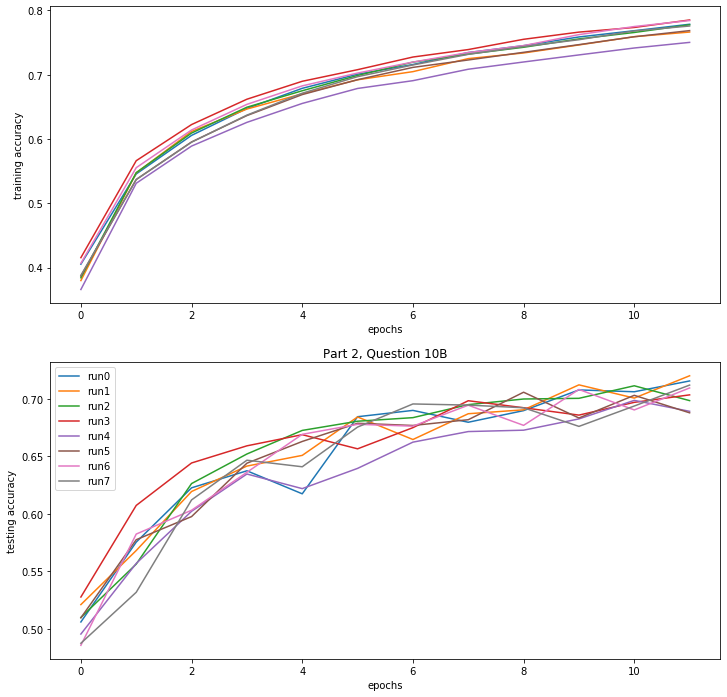

In [95]:
fig, ax = plt.subplots(2, figsize=(12,12))
for n in range(8):  # Reduced number of runs slightly to improve the runtime
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )

    model.fit(x_train, y_train, epochs=12, validation_data=(x_test, y_test), verbose=0)
    ax[0].plot(model.history.history['accuracy'], label=f'run{n}')
    ax[1].plot(model.history.history['val_accuracy'], label=f'run{n}')
    print('Validation accuracy: ', model.history.history['val_accuracy'])

plt.title('Part 2, Question 10B')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing accuracy')
ax[1].legend()
plt.show()

That actually ended up reducing the testing accuracy slightly.

run 0
Validation accuracy:  [0.5169, 0.5664, 0.6167, 0.6492, 0.6547, 0.6978, 0.6959, 0.6918, 0.6874, 0.7057, 0.6943, 0.701]
run 1
Validation accuracy:  [0.5036, 0.6255, 0.65, 0.6883, 0.6872, 0.6958, 0.7055, 0.6907, 0.7007, 0.6887, 0.6922, 0.6956]
run 2
Validation accuracy:  [0.5125, 0.6051, 0.6392, 0.6815, 0.6975, 0.7041, 0.6965, 0.6913, 0.7259, 0.7086, 0.7036, 0.724]
run 3
Validation accuracy:  [0.5434, 0.6267, 0.6681, 0.6966, 0.6852, 0.7063, 0.7053, 0.7171, 0.7174, 0.7063, 0.6922, 0.7083]
run 4
Validation accuracy:  [0.5588, 0.643, 0.6673, 0.6769, 0.7043, 0.7113, 0.7227, 0.7171, 0.7216, 0.7021, 0.72, 0.7156]
run 5
Validation accuracy:  [0.5501, 0.6198, 0.675, 0.6859, 0.6947, 0.7117, 0.7138, 0.7179, 0.7193, 0.6926, 0.7267, 0.7032]
run 6
Validation accuracy:  [0.5439, 0.6182, 0.6558, 0.6858, 0.6956, 0.7019, 0.7071, 0.6991, 0.709, 0.6902, 0.7033, 0.7027]
run 7
Validation accuracy:  [0.5488, 0.6197, 0.6654, 0.6872, 0.7023, 0.6871, 0.7039, 0.705, 0.7028, 0.7107, 0.711, 0.7018]


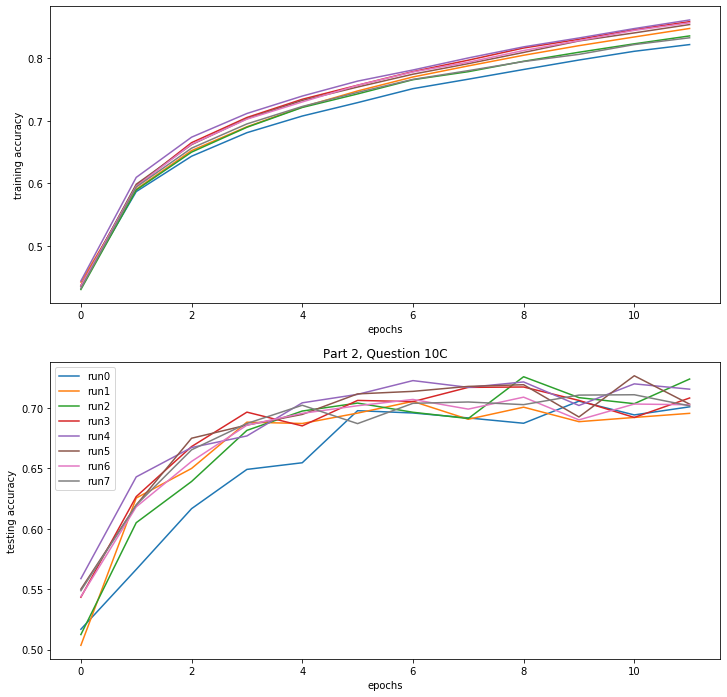

In [99]:
fig, ax = plt.subplots(2, figsize=(12,12))
for n in range(8):  # Reduced number of runs slightly to improve the runtime
    print(f'run {n}')
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )

    model.fit(x_train, y_train, epochs=12, validation_data=(x_test, y_test), verbose=0)
    ax[0].plot(model.history.history['accuracy'], label=f'run{n}')
    ax[1].plot(model.history.history['val_accuracy'], label=f'run{n}')
    print('Validation accuracy: ', model.history.history['val_accuracy'])

plt.title('Part 2, Question 10C')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('training accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('testing accuracy')
ax[1].legend()
plt.show()